In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
import os
import random
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!git clone https://github.com/femartip/Nuclei-Segmentation.git

Cloning into 'Nuclei-Segmentation'...
remote: Enumerating objects: 42082, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 42082 (delta 0), reused 2 (delta 0), pack-reused 42080
Receiving objects: 100% (42082/42082), 372.82 MiB | 48.05 MiB/s, done.
Resolving deltas: 100% (11025/11025), done.
Updating files: 100% (33893/33893), done.


In [ ]:
%cd Nuclei-Segmentation/

/content/Nuclei-Segmentation/Nuclei-Segmentation


# Load Images

In [ ]:
seed = 2023
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = './data/stage1_train/'
#TEST_PATH = './data/stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids = next(os.walk(TEST_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)



In [ ]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_

    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    X[n] = img

    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 

100%|██████████| 670/670 [04:05<00:00,  2.73it/s]


# Dividing Images

In [ ]:
def create_dataset(image, kmeans, n_clusters):
    X = np.zeros((len(image), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    y = np.zeros((len(image)), dtype=np.uint8)
    for i in range(0, len(image)):
        X[i] = image[i]
        y[i] = kmeans.labels_[i]
    return X, y

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from sklearn.cluster import KMeans

model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

featureslist = []
for i in range(0, len(X)):
    try:
        img_data = np.expand_dims(X[i], axis=0)
        #print(img_data.shape)
        img_data = preprocess_input(img_data)
        features = np.array(model.predict(img_data))
        featureslist.append(features.flatten())
    except:
        continue
n_clusters = 6
# Three labels: Big, small and one nuclei
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(np.array(featureslist))

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
X_split, y_split = create_dataset(X, kmeans, n_clusters)

# Preprocessing

In [ ]:
def pipeline(X):
    X_greyscale_bright = np.zeros((len(X), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    for i in range(0, len(X)):
        X_greyscale_bright[i] = np.dot(X[i][...,:3], [0.2989, 0.5870, 0.1140])
        X_greyscale_bright[i] = X_greyscale_bright[i] + 25

    return X_greyscale_bright

In [ ]:
X_processed = pipeline(X)
#Add one channel to the images
X_processed = np.expand_dims(X_processed, axis=3)

# Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.1, random_state=42, stratify=y_split)

# Model

*para evaluar el model, por ahora yo usaria binary_cossentropy y accuracy, tb podemos intentat añadir MeanIoU q es lo q dijo por teams

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f+y_pred_f) + smooth)

In [ ]:
def dice_coef_loss(y_true, y_pred):
    return 1.0-dice_coef(y_true, y_pred)

In [ ]:
def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    iou = K.mean((intersection + 1) / (union + 1), axis=0)
    return iou

In [ ]:
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

In [ ]:
def plot(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mean_iou'], label='train')
    plt.plot(history.history['val_mean_iou'], label='validation')
    plt.title('Mean IoU')
    plt.legend()
    plt.show()

In [ ]:
# The convolation block 
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    return x

In [ ]:
# The encoder block
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    
    return x, p

In [ ]:
# The decoder block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [ ]:
def unet_baseline(input_shape, LR):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)

    b1 = conv_block(p2, 64)

    d1 = decoder_block(b1, s2, 32)
    d2 = decoder_block(d1, s1, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d2)

    modelUnet = Model(inputs=inputs, outputs=outputs, name="BaselineUNET")

    return modelUnet

In [ ]:
batch_size = 64
batches_per_epoch = int(len(train_ids)/batch_size) 
epochs = 100
LR = 0.0001

model = unet_baseline((128, 128, 1), LR)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss=dice_coef_loss, metrics=[mean_iou])
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=tf.keras.callbacks.TensorBoard(log_dir='./logs'))

model_savepath = "unet_1"  

Model: "BaselineUNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_228 (Conv2D)            (None, 128, 128, 16  160         ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_208 (Batch  (None, 128, 128, 16  64         ['conv2d_228[0][0]']             
 Normalization)                 )                                                      

In [ ]:
model.save(model_savepath)

In [ ]:
print("Final accuracy on train set:", history.history['mean_iou'][-1])
print("Final loss on train set:", history.history['loss'][-1])
print("Final accuracy on validations set:", history.history['val_mean_iou'][-1])
print("Final loss on validations set:", history.history['val_loss'][-1])

Final accuracy on train set: 0.8346036076545715
Final loss on train set: 0.19764123857021332
Final accuracy on validations set: 0.8423381447792053
Final loss on validations set: 0.1927657127380371


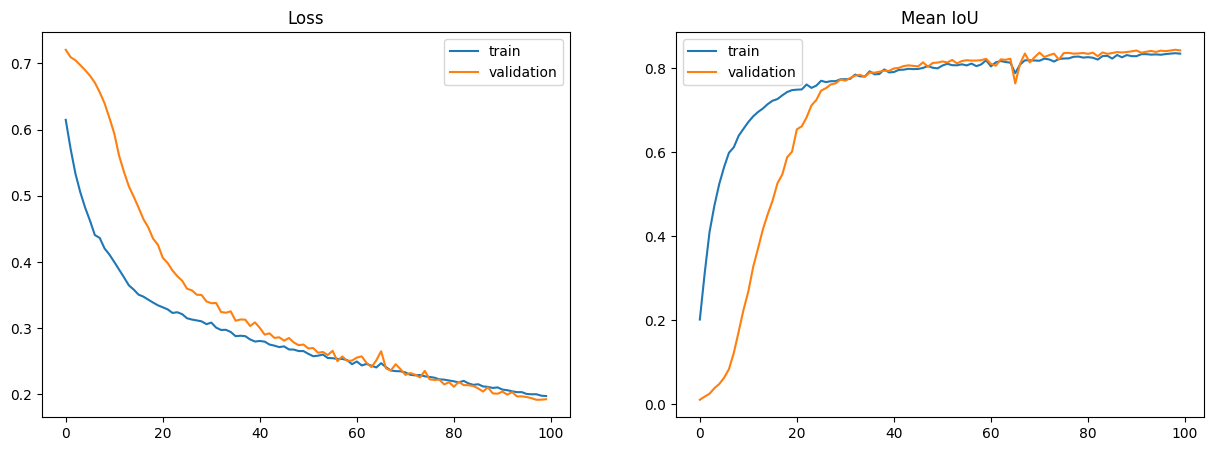

In [ ]:
plot(history)

1/1 [==============================] - 0s 23ms/step


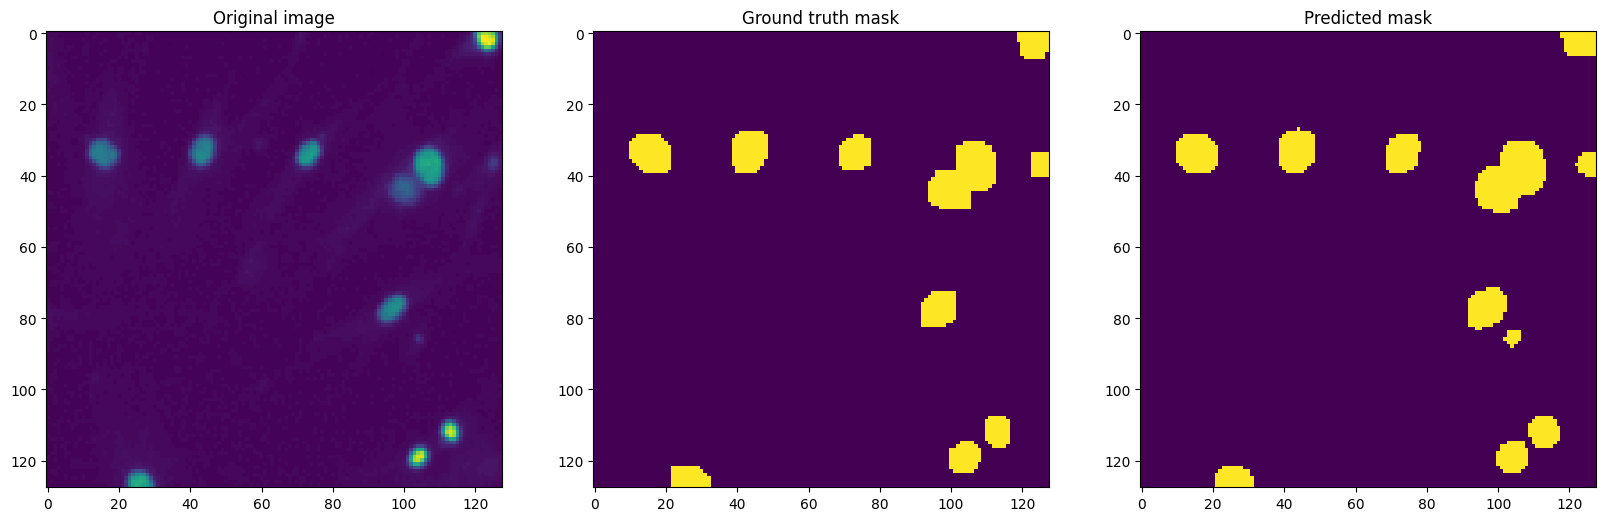

In [ ]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[idx:idx+1], verbose=1)

#Postprocessing threshold > 0.5
preds_train_t = (preds_train > 0.5).astype(np.uint8)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Original image')
plt.imshow(X_train[idx])
plt.subplot(1,3,2)
plt.title('Ground truth mask')
plt.imshow(np.squeeze(y_train[idx]))
plt.subplot(1,3,3)
plt.title('Predicted mask')
plt.imshow(np.squeeze(preds_train_t))
plt.show()